In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

In [2]:
def Performance_Metrics(model, test_features, test_labels):
    predictions = model.predict(test_features)
    pred_prob   = model.predict_proba(test_features)[:, 1]
    
    print('\nModel performance on test data:')
    
    pre, rec, thresholds = metrics.precision_recall_curve(test_labels, pred_prob)
    
    accuracy  = metrics.accuracy_score(test_labels, predictions)
    F1        = metrics.f1_score(test_labels, predictions)
    precision = metrics.precision_score(test_labels, predictions)
    recall    = metrics.recall_score(test_labels, predictions)
    mcc       = metrics.matthews_corrcoef(test_labels, predictions)
    auc       = metrics.roc_auc_score(test_labels, pred_prob)
    aucpr     = metrics.auc(rec, pre)
    
    header = ['Metric', 'Test']
    table  = [
               ['Accuracy',  accuracy],
               ['F1',        F1],
               ['Precision', precision],
               ['Recall',    recall],
               ['MCC',       mcc],
               ['PR-AUC',    aucpr],
               ['AUC',       auc]
             ]
    print(pd.DataFrame(table, columns = header))
    
    return np.array([col[1] for col in table])

In [3]:
def ROC_Curve_CV(aucs, fprs, tprs):
    plt.style.use('ggplot')
    plt.figure()
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    
    interp_tprs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    n = len(aucs)
    colors = iter(cm.rainbow(np.linspace(1, 0, n)))
    for i in range(n):
        interp_tpr = np.interp(mean_fpr, fprs[i], tprs[i])
        interp_tpr[0] = 0.0
        interp_tprs.append(interp_tpr)
        
        plt.plot([0.0] + fprs[i], 
                 [0.0] + tprs[i], 
                 color = next(colors),
                 alpha = 0.4,
                 lw = 1,
                 label = 'ROC fold ' + str(i) + ' (area = %0.2f)' % aucs[i])
        
    plt.plot([0, 1], [0, 1],
             color = 'blue',
             alpha = 0.8,
             lw = 2,
             linestyle = '--',
             label = 'Chance')
    
    mean_tpr = np.mean(interp_tprs, axis = 0)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs, ddof = 1)
    plt.plot(mean_fpr, mean_tpr,
             color = 'red',
             alpha = 0.8,
             lw = 2,
             label = r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc))
    
    std_tpr = np.std(interp_tprs, axis = 0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper,
                     color = 'grey',
                     alpha = 0.2,
                     label = r'$\pm$ 1 std. dev.')
    
    plt.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left', borderaxespad = 0.)
    
    plt.show()
    
    return np.append(mean_tpr, std_auc)


Model performance on test data:
      Metric      Test
0   Accuracy  0.857143
1         F1  0.400000
2  Precision  0.500000
3     Recall  0.333333
4        MCC  0.331133
5     PR-AUC  0.258906
6        AUC  0.708333

Model performance on test data:
      Metric      Test
0   Accuracy  0.785714
1         F1  0.526316
2  Precision  0.384615
3     Recall  0.833333
4        MCC  0.462569
5     PR-AUC  0.448584
6        AUC  0.893519

Model performance on test data:
      Metric      Test
0   Accuracy  0.785714
1         F1  0.526316
2  Precision  0.384615
3     Recall  0.833333
4        MCC  0.462569
5     PR-AUC  0.441070
6        AUC  0.847222

Model performance on test data:
      Metric      Test
0   Accuracy  0.642857
1         F1  0.347826
2  Precision  0.235294
3     Recall  0.666667
4        MCC  0.217832
5     PR-AUC  0.229633
6        AUC  0.620370

Model performance on test data:
      Metric      Test
0   Accuracy  0.571429
1         F1  0.357143
2  Precision  0.238095
3     R

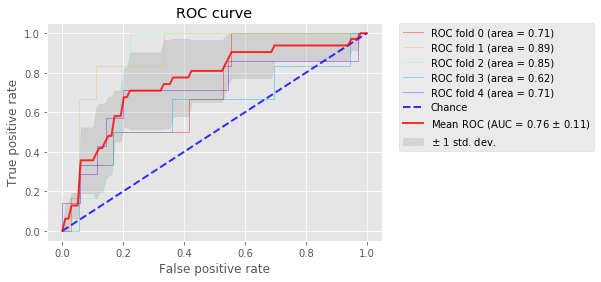

In [4]:
# For died within 30 days outcome
mean_perf = np.zeros(7)
std_perf = np.zeros(7)
auc_list = []
fpr_list = []
tpr_list = []

estimator = SVC(
    kernel = 'linear',
    probability = True,
    random_state = 0)

for i in range(5):
    # Import a sample binary outcome dataset
    train = pd.read_csv('train1_30_' + str(i) + '.csv')
    test = pd.read_csv('test1_30_' + str(i) + '.csv')
    
    # Separate feature matrix and labels
    features_train = train.drop(['ThirtyMo'], axis = 1)
    labels_train = train['ThirtyMo']
    features_test = test.drop(['ThirtyMo'], axis = 1)
    labels_test = test['ThirtyMo']
    
    # Fit the training data
    estimator.fit(X = features_train,
                  y = labels_train)
    
    # Print the performance of the model on the test data
    perf = Performance_Metrics(estimator, features_test, labels_test)
    mean_perf += perf / 5
    std_perf += np.square(perf) / 4
    
    # Store AUC, FPR, and TPR
    pred_prob = estimator.predict_proba(features_test)[:, 1]
    auc_list.append(metrics.roc_auc_score(labels_test, pred_prob))
    fpr, tpr, _ = metrics.roc_curve(labels_test, pred_prob)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    
std_perf = np.sqrt(std_perf - 5 / 4 * mean_perf**2)

print('\nModel performance for 5-fold cross-validation:')
header = ['Metric', 'Mean', 'Standard deviation']
table  = [
            ['Accuracy',  mean_perf[0], std_perf[0]],
            ['F1',        mean_perf[1], std_perf[1]],
            ['Precision', mean_perf[2], std_perf[2]],
            ['Recall',    mean_perf[3], std_perf[3]],
            ['MCC',       mean_perf[4], std_perf[4]],
            ['PR-AUC',    mean_perf[5], std_perf[5]],
            ['AUC',       mean_perf[6], std_perf[6]],
         ]
print(pd.DataFrame(table, columns = header))

# Plot the ROC Curve
ROC_save_30 = ROC_Curve_CV(auc_list, fpr_list, tpr_list)
np.savetxt('ROC_save1_30_SVM.csv', ROC_save_30, delimiter = ',')


Model performance on test data:
      Metric      Test
0   Accuracy  0.718750
1         F1  0.400000
2  Precision  0.750000
3     Recall  0.272727
4        MCC  0.323287
5     PR-AUC  0.758435
6        AUC  0.878788

Model performance on test data:
      Metric      Test
0   Accuracy  0.750000
1         F1  0.636364
2  Precision  0.636364
3     Recall  0.636364
4        MCC  0.445887
5     PR-AUC  0.611554
6        AUC  0.852814

Model performance on test data:
      Metric      Test
0   Accuracy  0.625000
1         F1  0.538462
2  Precision  0.466667
3     Recall  0.636364
4        MCC  0.243095
5     PR-AUC  0.584685
6        AUC  0.718615

Model performance on test data:
      Metric      Test
0   Accuracy  0.645161
1         F1  0.620690
2  Precision  0.473684
3     Recall  0.900000
4        MCC  0.406736
5     PR-AUC  0.471557
6        AUC  0.757143

Model performance on test data:
      Metric      Test
0   Accuracy  0.580645
1         F1  0.551724
2  Precision  0.444444
3     R

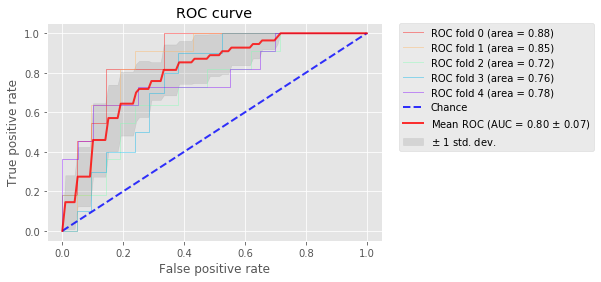

In [5]:
# For died within 90 days outcome
mean_perf = np.zeros(7)
std_perf = np.zeros(7)
auc_list = []
fpr_list = []
tpr_list = []

estimator = SVC(
    kernel = 'linear',
    probability = True,
    random_state = 0)

for i in range(5):
    # Import a sample binary outcome dataset
    train = pd.read_csv('train1_90_' + str(i) + '.csv')
    test = pd.read_csv('test1_90_' + str(i) + '.csv')
    
    # Separate feature matrix and labels
    features_train = train.drop(['NinetyMo'], axis = 1)
    labels_train = train['NinetyMo']
    features_test = test.drop(['NinetyMo'], axis = 1)
    labels_test = test['NinetyMo']
    
    # Fit the training data
    estimator.fit(X = features_train,
                  y = labels_train)
    
    # Print the performance of the model on the test data
    perf = Performance_Metrics(estimator, features_test, labels_test)
    mean_perf += perf / 5
    std_perf += np.square(perf) / 4
    
    # Store AUC, FPR, and TPR
    pred_prob = estimator.predict_proba(features_test)[:, 1]
    auc_list.append(metrics.roc_auc_score(labels_test, pred_prob))
    fpr, tpr, _ = metrics.roc_curve(labels_test, pred_prob)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    
std_perf = np.sqrt(std_perf - 5 / 4 * mean_perf**2)

print('\nModel performance for 5-fold cross-validation:')
header = ['Metric', 'Mean', 'Standard deviation']
table  = [
            ['Accuracy',  mean_perf[0], std_perf[0]],
            ['F1',        mean_perf[1], std_perf[1]],
            ['Precision', mean_perf[2], std_perf[2]],
            ['Recall',    mean_perf[3], std_perf[3]],
            ['MCC',       mean_perf[4], std_perf[4]],
            ['PR-AUC',    mean_perf[5], std_perf[5]],
            ['AUC',       mean_perf[6], std_perf[6]]
         ]
print(pd.DataFrame(table, columns = header))

# Plot the ROC Curve
ROC_save_90 = ROC_Curve_CV(auc_list, fpr_list, tpr_list)
np.savetxt('ROC_save1_90_SVM.csv', ROC_save_90, delimiter = ',')